In [39]:
%config IPCompleter.greedy=True
%matplotlib notebook
import libs.lib as lib
lib.setup_logger('info', logfile='/home/adams/apertif/BP/8030111_3C286_0.log')
import apercal

import bp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

root - INFO : Logging started!
root - INFO : Logging started!
root - INFO : Logging started!
root - INFO : Logging started!
root - INFO : To see the log in a bash window use the following command:
root - INFO : To see the log in a bash window use the following command:
root - INFO : To see the log in a bash window use the following command:
root - INFO : To see the log in a bash window use the following command:
root - INFO : tail -n +1 -f /home/adams/apertif/BP/8030111_3C286_0.log
root - INFO : tail -n +1 -f /home/adams/apertif/BP/8030111_3C286_0.log
root - INFO : tail -n +1 -f /home/adams/apertif/BP/8030111_3C286_0.log
root - INFO : tail -n +1 -f /home/adams/apertif/BP/8030111_3C286_0.log


Below is where the bandpass stability is explored; above is where the basic data preparation is undertaken

In [6]:
#This step should only need to be done once - this does the calibration and can take a few minutes
#The only reason to redo is if a different time interval is desired, or the data has been reflagged

cfgfile='/home/adams/apertif/BP/8030111_3C286_0.cfg'
inttime='30'
bp.do_bp(cfgfile,inttime='30')

CROSSCAL - INFO : ### Configuration file /home/adams/ipython-notebooks/commissioning/01/cfg/8030111_3C286_0.cfg successfully read! ###
CROSSCAL - INFO : # Moved to directory /data/adams/apertif/busydays/bp_rc_after/00/crosscal #


3C286.mir
calibration finished


In [3]:
#This reads the bandpass solutions derived above
#Unless the bp solution has been changed above, this doesn't need to be redone within a python session

#However, this reads the solutions into a numpy array in the active python session
#And so must be redone everytime the kernel is restarted.

cfgfile='/home/adams/apertif/BP/8030111_3C286_0.cfg'
values, freqs = bp.get_bpsols(cfgfile)


print values.shape,freqs.shape

CROSSCAL - INFO : ### Configuration file /home/adams/apertif/BP/8030111_3C286_0.cfg successfully read! ###


read calibration solutions into numpy array
(11, 11008, 24) (11008,)


In [4]:
#define the telescope names
#this is used generally throughout the notebook
tnames = ('RT2','RT3','RT4','RT5','RT6','RT7','RT8','RT9','RTA','RTB','RTC')

<IPython.core.display.Javascript object>


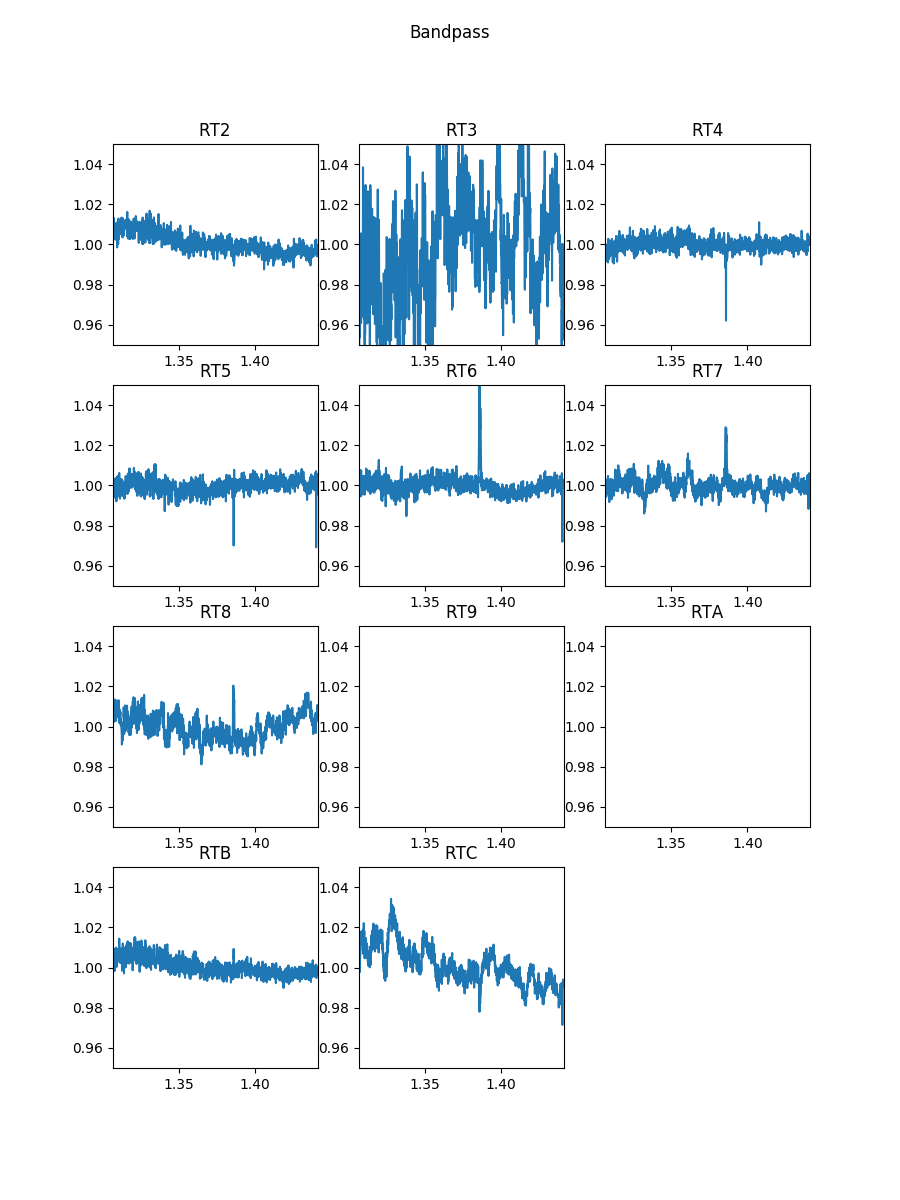

In [6]:
fig=bp.plot_last_bp_per_ant(values,freqs,tnames,nchan=8,nx=3,ymin=0.95,ymax=1.05,plotsize=3)

I can make lots of nice plots, but now we want to actually address the question of if we are meeting the science requirements. The requirements state that during a 12hr measurement the bandpass variation is less than 1:10^4 over a spectral range of 10 MHz. 
<br> <br>
To do this, will try taking 10 MHz windows and finding average rms. Will then want to plot this for center of every 10 MHz window (lose edges of bandpass). Can try with different channel smoothings. 
<br> <br>
Then will also want to get average deviation of all 10 MHz windows and show that as function of time for each antenna. Want to think about different things to plot: average deviation from one, total deviation, etc.

In [82]:
#let's start!
#define a function that will take bandpass solutions, bin a given set of channels, and then
#calculate rms in sliding 10 MHz windows
#Of course, this needs to be for normalized data

#input I will need: (values,freqs,nchan=8,normscan=0)

nchan = 8

def get_metrics(values,freqs,nchan=8,normscan=0,window=10):
    #window defined in MHz
    #first, get normalized data binned approporiately
    plotvals,plotfreqs = bp.get_norm_bpsols(values,freqs,nchan=nchan,normscan=normscan)

    #first, figure out how many channels of my averaged data are in 10 MHz
    chwid = 400./(512.*64.) #512 subbands across 400 MHz, 64 chans in each subband
    binchwid = chwid*np.float(nchan) #width of binned chan in MHz

    nin10 = (window/binchwid) #get number of chans in 10 MHz

    #now i want to create arrays to hold values I want to calculate
    #match vals in shape
    avgdev = np.empty(plotvals.shape)
    totdev = np.empty(plotvals.shape)
    avgtotdev = np.empty(plotvals.shape)
    mean = np.empty(plotvals.shape)

    #now iterate through antennas and solution intervals
    #use pandas 'rolling' to calculate things in windows
    for ant in range(plotvals.shape[0]):
        for sol in range(plotvals.shape[2]):
            #if i just want running mean, cumsum is a good way to do that:
            #turn out pandas has great functionality for this, and is in apercal environment
            fs = pd.Series(plotvals[ant,:,sol],index=plotfreqs)
            window_mean = fs.rolling(window=np.int(nin10)).mean()
            
            fs_zero = pd.Series((plotvals[ant,:,sol]-1.),index=plotfreqs)
            window_avgdev = fs_zero.rolling(window=np.int(nin10)).mean()
            
            fs_abs = pd.Series(np.abs((plotvals[ant,:,sol]-1.)),index=plotfreqs)
            window_totdev = fs_abs.rolling(window=np.int(nin10)).sum()
            window_avgtotdev = fs_abs.rolling(window=np.int(nin10)).mean()
            
            #fs.rolling(window=10).mean().plot(style='k')
            avgdev[ant,:,sol] = window_avgdev
            totdev[ant,:,sol] = window_totdev
            avgtotdev[ant,:,sol] = window_avgtotdev
            mean[ant,:,sol] = window_mean

    return mean,avgtotdev


In [83]:
#now maybe have a function for getting mean, avgdev and totdev
#so let's move to plotting
#want to do antenna based plots, plotting different vals, first
#also want to plot a single time to start
#can adapt/play with this as needed

def plot_per_ant_metrics(values,freqs,ant,plotscan=-1,nchan=8,normscan=0,window=10):
    #choose which scan to plot
    #first get data, just in case I want to plot it also
    plotvals,plotfreqs = bp.get_norm_bpsols(values,freqs,nchan=nchan,normscan=normscan)
    
    #then get metrics
    mean,avgtotdev = get_metrics(values,freqs,nchan=nchan,normscan=normscan,window=window)
    
    #for now, think I only care about mean, avgtotdev
    
    #now plot
    #want to plot solution, normalized solution (same y-range), 
    #avgtot dev, max(avgtotdev) over time
    #get the information for that last part:
    
    maxdev = np.empty(plotvals.shape[2])
    
    for sol in range(plotvals.shape[2]):
        maxdev[sol] = np.nanmax(avgtotdev[ant,:,sol])
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
    
    f1 = plotfreqs[0]
    f2 = plotfreqs[-1]
    norm1 = 0.97
    norm2 =1.03
    
    dev1 = 0
    dev2 = 0.01
    
    sol1=0
    sol2=plotvals.shape[2] -1
    
    ax1.plot(plotfreqs,plotvals[ant,:,plotscan],c='k')
    ax1.plot([f1,f2],[1,1],c='red')
    ax1.set_title('Normalized solution')
    #ax1.axis([f1,f2,norm2,norm2])
    
    ax2.plot(plotfreqs,mean[ant,:,plotscan],c='k')
    ax2.plot([f1,f2],[1,1])
    ax2.set_title('Average over '+str(window)+'MHz window')
    #ax2.axis([f1,f2,norm2,norm2])
    
    ax3.plot(plotfreqs,avgtotdev[ant,:,plotscan],c='k')
    ax3.set_title('Total average deviation over '+str(window)+'MHz window')   
    ax3.axis([f1,f2,dev1,dev2])
    
    ax4.plot(np.arange(plotvals.shape[2]),maxdev,c='k')
    ax4.set_title('Maximum deviation over '+str(window)+'MHz window') 
    ax4.set_xlabel('Solution interval')
    ax4.axis([sol1,sol2,dev1,dev2])
    
    return fig


<IPython.core.display.Javascript object>


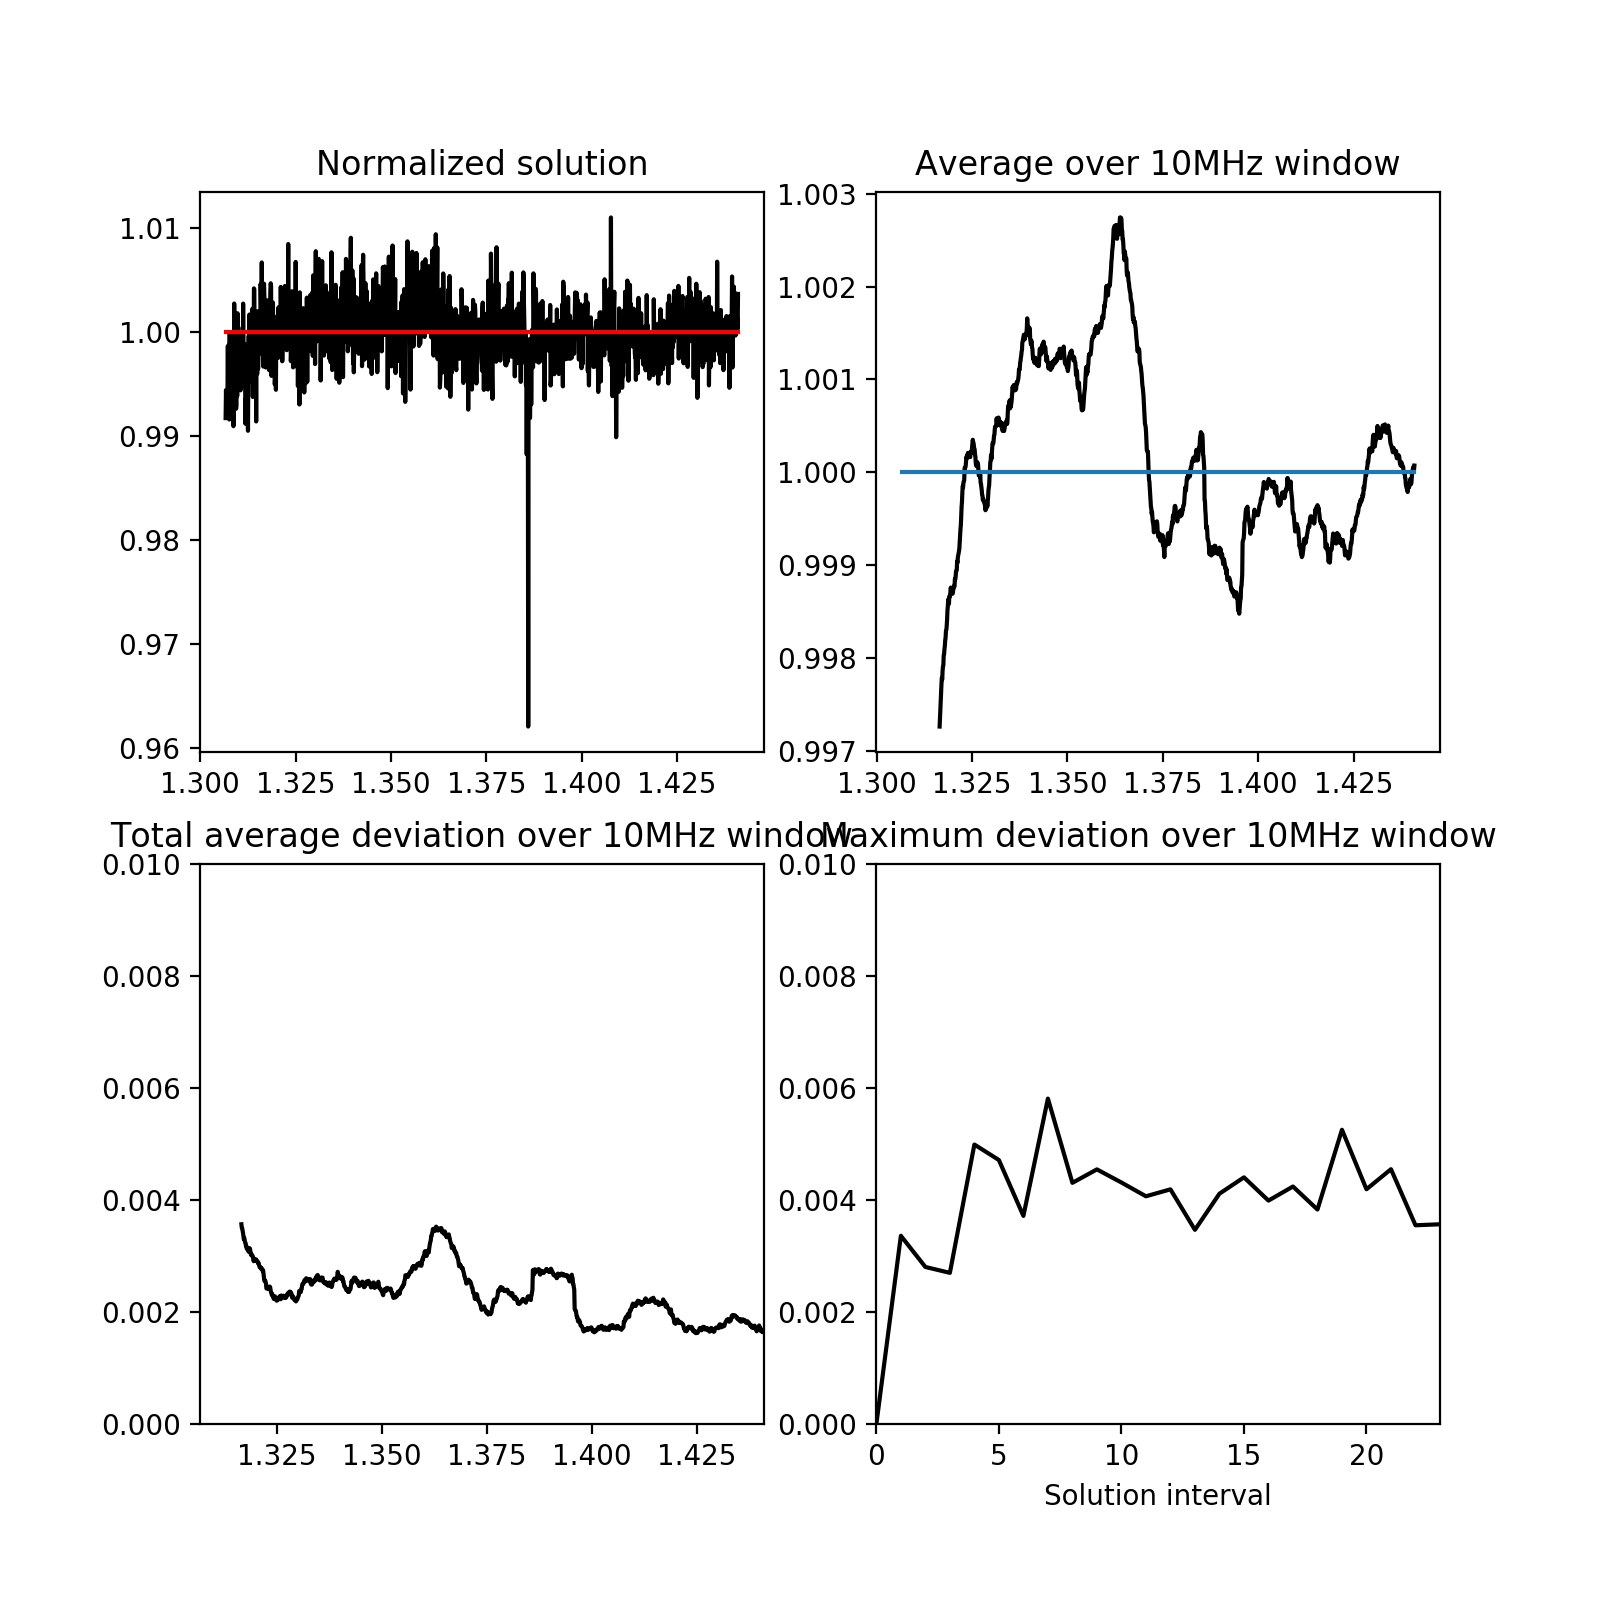

In [84]:
fig = plot_per_ant_metrics(values,freqs,2)

<IPython.core.display.Javascript object>


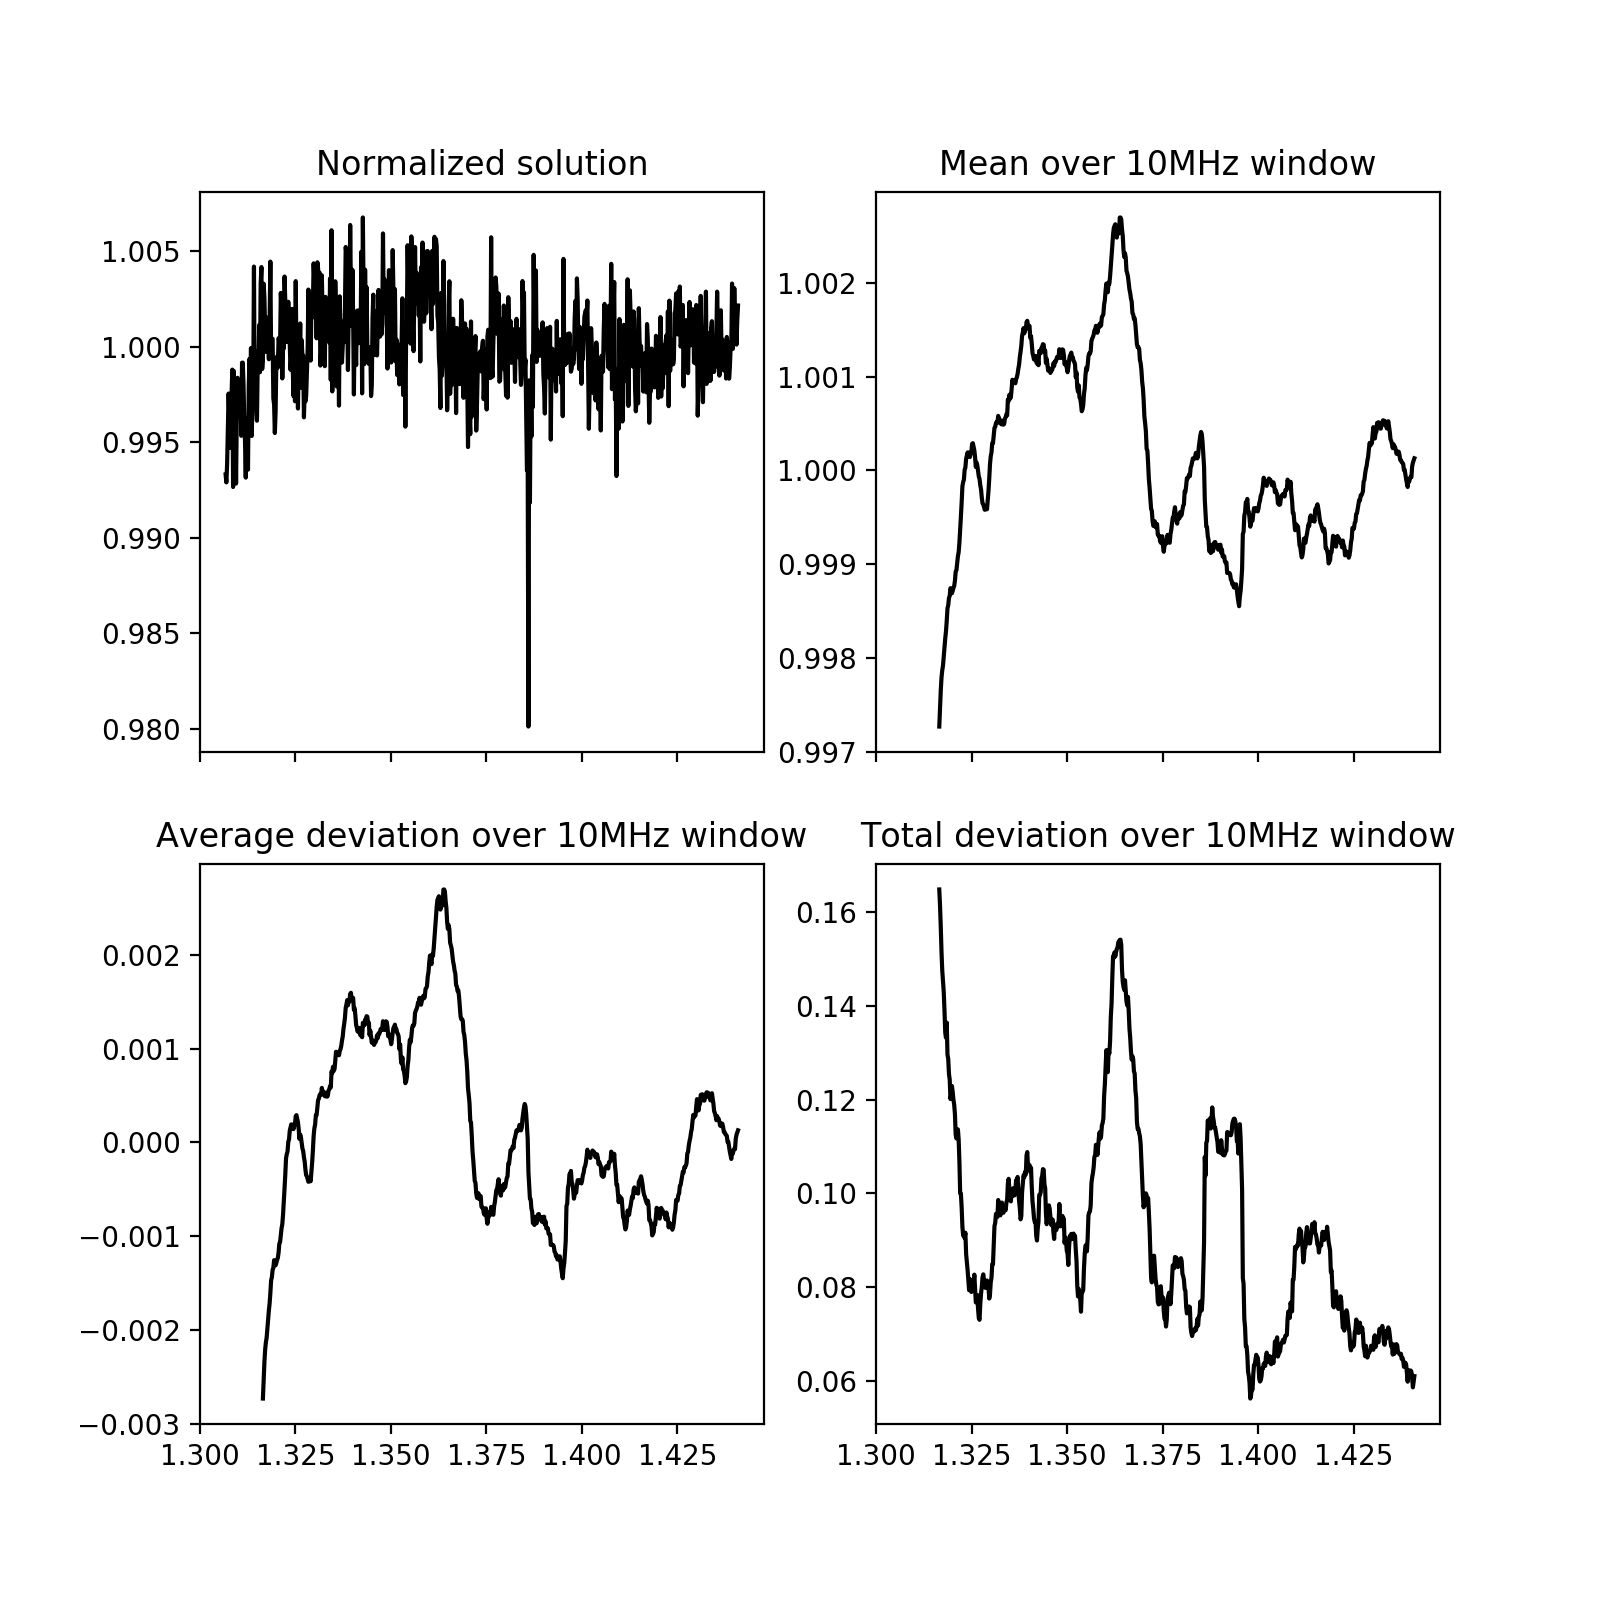

In [51]:
fig = plot_per_ant_metrics(values,freqs,2,nchan=16,window=10)

<IPython.core.display.Javascript object>


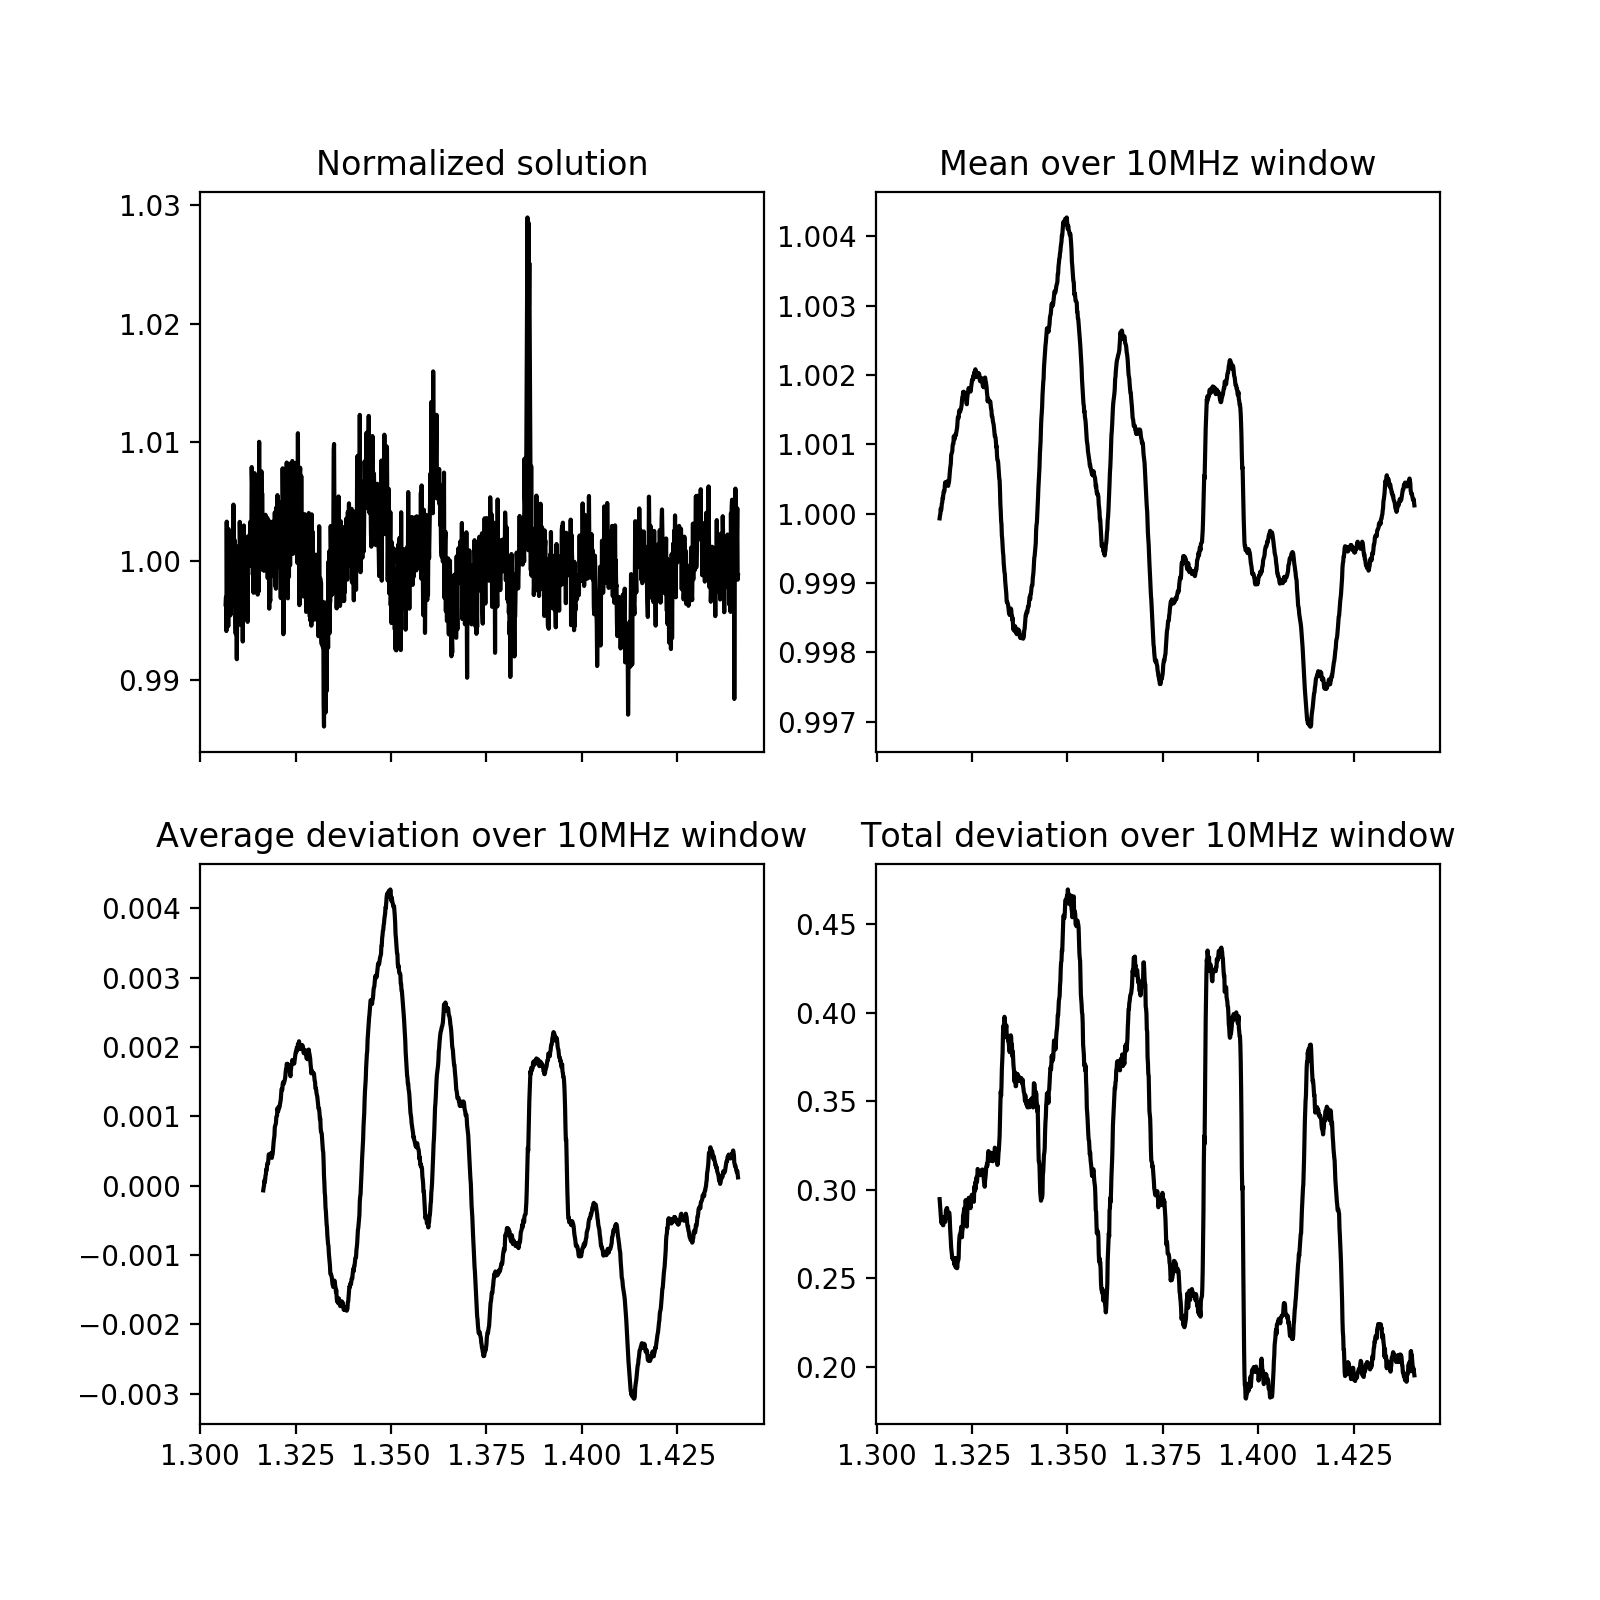

In [49]:
fig = plot_per_ant_metrics(values,freqs,5,nchan=8)

In [ ]:
#Useful code for plotting in pandas

fs = pd.Series(plotvals[0,:,-1],index=plotfreqs)
fs.plot(style='k--')
fs.rolling(window=10).mean().plot(style='r:')
fs.rolling(window=np.int(nin10)).mean().plot(style='r')